In [1]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from google.colab import drive

In [2]:
class image_data_set(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        return {'data': self.data[index], 'label': self.labels[index]}

In [3]:
def print_data_analysis(present_lighting_sufficient_data, 
                        present_lighting_insufficient_data, 
                        not_present_lighting_sufficient_data, 
                        not_present_lighting_insufficient_data):
  
    subplot = plt.subplot()
    data_lengthes = np.array([
        [len(present_lighting_sufficient_data), len(present_lighting_insufficient_data)], 
        [len(not_present_lighting_sufficient_data), len(not_present_lighting_insufficient_data)]
    ])
    sns.heatmap(data_lengthes, annot=True, fmt='g', cmap='Blues')
    subplot.xaxis.set_ticklabels(['Lighting Sufficient', 'Lighting Not Sufficient'])
    subplot.yaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    plt.show()

def get_image_tensor(file_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    image = Image.open(file_path)
    return transform(image)

def get_data_and_labels(directory_path, label):
    image_tensors, labels = [], []
    for file in os.listdir(directory_path):
        if file.endswith(".JPG"):
            file_path = directory_path + file
            image_tensor = get_image_tensor(file_path)

            image_tensors.append(image_tensor)
            labels.append(label)
            
    return image_tensors, labels

def get_data_for_label(file_pathes, label): 

  all_data, all_labels = [], []
  for file_path in file_pathes:
      data, labels = get_data_and_labels(file_path, label)
      all_data.extend(data)
      all_labels.extend(labels)

  return all_data, all_labels
    
def get_data_sets(present_file_pathes_lighting_sufficient, 
                  present_file_pathes_lighting_insufficient,
                  not_present_file_pathes_lighting_sufficient,
                  not_present_file_pathes_lighting_insufficient): 

    present_ls_data, present_ls_labels = get_data_for_label(present_file_pathes_lighting_sufficient, 1)
    present_lis_data, present_lis_labels = get_data_for_label(present_file_pathes_lighting_insufficient, 1)
    not_present_ls_data, not_present_ls_labels = get_data_for_label(not_present_file_pathes_lighting_sufficient, 0)
    not_present_lis_data, not_present_lis_labels = get_data_for_label(not_present_file_pathes_lighting_insufficient, 0)

    print_data_analysis(present_ls_data, present_lis_data, not_present_ls_data, not_present_lis_data)
    
    ls_data = present_ls_data + not_present_ls_data
    ls_labels = present_ls_labels + not_present_ls_labels

    lis_data = present_lis_data + not_present_lis_data
    lis_labels = present_lis_labels + not_present_lis_labels
    
    ls_training_data, ls_testing_data, ls_training_labels, ls_testing_labels = train_test_split(ls_data, ls_labels)
    lis_training_data, lis_testing_data, lis_training_labels, lis_testing_labels = train_test_split(lis_data, lis_labels)

    training_data = ls_training_data + lis_training_data
    testing_data = ls_testing_data + lis_testing_data
    training_labels = ls_training_labels + lis_training_labels
    testing_labels = ls_testing_labels + lis_testing_labels
    
    print("\nNumber of training photos: " + str(len(training_data)))
    print("Number of testing photos: " + str(len(testing_data)))
    print("Number of lighting sufficient testing photos: " + str(len(ls_testing_data)))
    print("Number of lighting insufficient testing photos: " + str(len(lis_testing_data)))
    
    training_data_set = image_data_set(training_data, training_labels)
    testing_data_set = image_data_set(testing_data, testing_labels)
    ls_testing_data_set = image_data_set(ls_testing_data, ls_testing_labels)
    lis_testing_data_set = image_data_set(lis_testing_data, lis_testing_labels)
    
    return training_data_set, testing_data_set, ls_testing_data_set, lis_testing_data_set

def get_loaders(training_data_set, testing_data_set, ls_testing_data_set, lis_testing_data_set, batch_size):
    training_loader = torch.utils.data.DataLoader(dataset = training_data_set,
                                                  batch_size = batch_size,
                                                  shuffle = True)

    testing_loader = torch.utils.data.DataLoader(dataset = testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    ls_testing_loader = torch.utils.data.DataLoader(dataset = ls_testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    lis_testing_loader = torch.utils.data.DataLoader(dataset = lis_testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    return training_loader, testing_loader, ls_testing_loader, lis_testing_loader

In [4]:
def print_image(image_tensor, prediction):
    if(prediction == 1):
        prediction_string = "Wildlife Present"
    else:
        prediction_string = "No Wildlife Present"

    #Alternative normalized RGB visualization: plt.imshow(image_tensor.cpu().permute(1, 2, 0).numpy())
    plt.imshow(image_tensor[0].cpu(), cmap="gray")
    plt.title("Incorrectly Predicted " + prediction_string) 
    plt.show()

def print_testing_analysis(all_labels, all_predictions, title):
    subplot = plt.subplot()

    cf_matrix = confusion_matrix(all_labels, all_predictions, labels=[1, 0])
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Labels')
    subplot.set_title(title + ' Testing Confusion Matrix')
    subplot.xaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    subplot.yaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    print(title + " Accuracy: " + str(accuracy))

    precision, recall, f_score, support = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    print(title + " Precision: " + str(precision))
    print(title + " Recall: " + str(recall))
    print(title + " F-Score: " + str(f_score))

def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(training_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/len(training_loader.dataset)
    return loss, accuracy

def test(model, testing_loader, criterion, print_incorrect_images):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for i, data in enumerate(testing_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        for index, prediction in enumerate(predictions):
            if(prediction == labels[index]):
                num_correct += 1
            elif(print_incorrect_images):
                print_image(data[index], prediction)

        all_labels.extend(labels.cpu())
        all_predictions.extend(predictions.cpu())
    
    loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/len(testing_loader.dataset)
    return loss, accuracy, all_labels, all_predictions

In [5]:
def train_and_test(model, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(5):
        print("epoch: " + str(epoch))
        
        training_loss, training_accuracy = train(model, training_loader, criterion, optimizer)
        print("training loss: " + str(training_loss) + " and training accuracy: " + str(training_accuracy))
        
        testing_loss, testing_accuracy, _, _ = test(model, testing_loader, criterion, False)
        print("testing loss: " + str(testing_loss) + " and testing accuracy: " + str(testing_accuracy))

    testing_loss, testing_accuracy, labels, predictions = test(model, testing_loader, criterion, True)
    print_testing_analysis(labels, predictions, "Overall")

    testing_loss, testing_accuracy, labels, predictions = test(model, ls_testing_loader, criterion, False)
    print_testing_analysis(labels, predictions, "Lighting Sufficient")

    testing_loss, testing_accuracy, labels, predictions = test(model, lis_testing_loader, criterion, False)
    print_testing_analysis(labels, predictions, "Lighting Insufficient")

In [6]:
def train_and_test_ResNet50(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes):
    print("\nTraining and Testing ResNet50")
    resnet50 = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
    resnet50.fc.out_features = num_classes
    train_and_test(resnet50, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device)

def train_and_test_ResNet152(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes):
    print("\nTraining and Testing ResNet152")
    resnet152 = models.resnet152(weights = models.ResNet152_Weights.DEFAULT)
    resnet152.fc.out_features = num_classes
    train_and_test(resnet152, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device)

def train_and_test_ViT_L_16(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes):
    print("\nTraining and Testing Vision Transformer Large 16")
    vit_l_16 = models.vit_l_16(weights = models.ViT_L_16_Weights.DEFAULT)
    vit_l_16.heads.out_features = num_classes
    train_and_test(vit_l_16, training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device)

#Orchestration

In [10]:
# Use this to connect to Google Drive in Google Colab
drive.mount('/content/drive')

# Use this to unzip file in Google Colab
!unzip -qq drive/MyDrive/winter_manually_labeled_wildlife_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


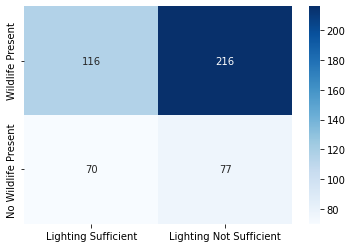


Number of training photos: 358
Number of testing photos: 121
Number of lighting sufficient testing photos: 47
Number of lighting insufficient testing photos: 74


In [11]:
present_file_pathes_ls = [
  "winter_manually_labeled_wildlife_data/MP180.3_NGILCHRIST/present/lighting_sufficient/"
]

present_file_pathes_lis = [
  "winter_manually_labeled_wildlife_data/MP180.3_NGILCHRIST/present/lighting_insufficient/"
]

not_present_file_pathes_ls = [
  "winter_manually_labeled_wildlife_data/MP180.3_NGILCHRIST/not_present/lighting_sufficient/"
]

not_present_file_pathes_lis = [
  "winter_manually_labeled_wildlife_data/MP180.3_NGILCHRIST/not_present/lighting_insufficient/"
]

num_classes = 2
batch_size = 10

training_data_set, testing_data_set, ls_testing_data_set, lis_testing_data_set = get_data_sets(
    present_file_pathes_ls, 
    present_file_pathes_lis,
    not_present_file_pathes_ls,
    not_present_file_pathes_lis
)
training_loader, testing_loader, ls_testing_loader, lis_testing_loader = get_loaders(
    training_data_set, 
    testing_data_set, 
    ls_testing_data_set, 
    lis_testing_data_set, 
    batch_size
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()


Training and Testing ResNet50


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
training loss: 0.42019436579176833 and training accuracy: 0.3994413407821229
testing loss: 0.15583074363795194 and testing accuracy: 0.7355371900826446
epoch: 1
training loss: 0.05335478411789713 and training accuracy: 0.7821229050279329
testing loss: 0.03952011441396288 and testing accuracy: 0.8512396694214877
epoch: 2
training loss: 0.026963390222641343 and training accuracy: 0.88268156424581
testing loss: 0.03663644841140952 and testing accuracy: 0.8429752066115702
epoch: 3
training loss: 0.020939937579398715 and training accuracy: 0.9162011173184358
testing loss: 0.024376180300042648 and testing accuracy: 0.8925619834710744
epoch: 4
training loss: 0.01647515026800459 and training accuracy: 0.9301675977653632
testing loss: 0.02618547615187227 and testing accuracy: 0.9090909090909091


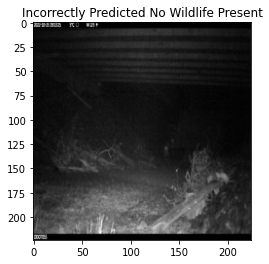

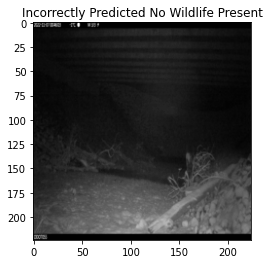

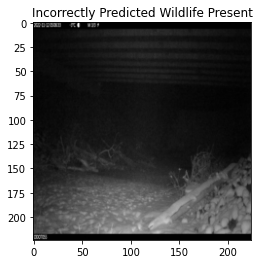

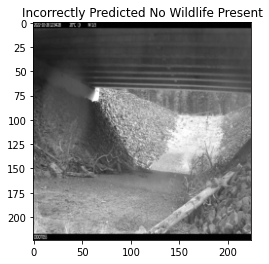

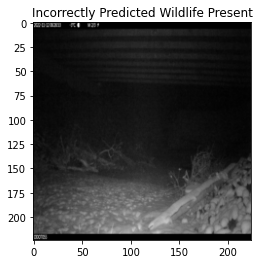

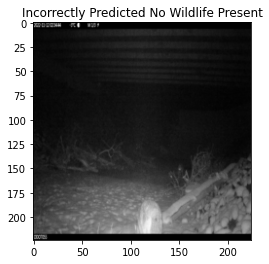

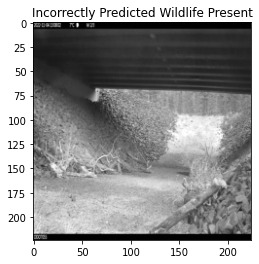

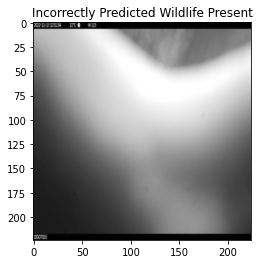

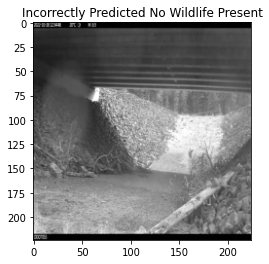

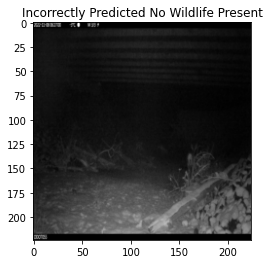

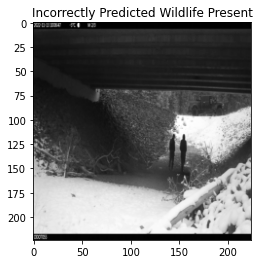

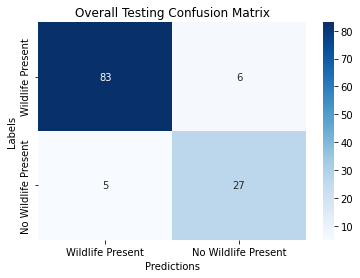

Overall Accuracy: 0.9090909090909091
Overall Precision: 0.9431818181818182
Overall Recall: 0.9325842696629213
Overall F-Score: 0.9378531073446328


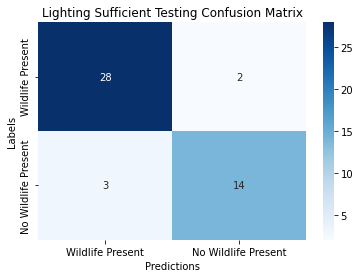

Lighting Sufficient Accuracy: 0.8936170212765957
Lighting Sufficient Precision: 0.9032258064516129
Lighting Sufficient Recall: 0.9333333333333333
Lighting Sufficient F-Score: 0.9180327868852459


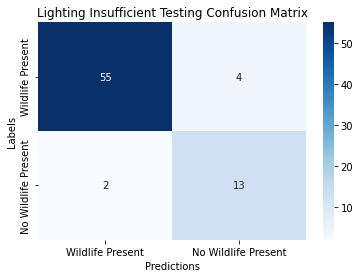

Lighting Insufficient Accuracy: 0.918918918918919
Lighting Insufficient Precision: 0.9649122807017544
Lighting Insufficient Recall: 0.9322033898305084
Lighting Insufficient F-Score: 0.9482758620689654


In [12]:
train_and_test_ResNet50(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes)


Training and Testing ResNet152


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch: 0
training loss: 0.39010437902625045 and training accuracy: 0.3547486033519553
testing loss: 0.08788271163674918 and testing accuracy: 0.71900826446281
epoch: 1
training loss: 0.06007857054638463 and training accuracy: 0.7178770949720671
testing loss: 0.050523497718424834 and testing accuracy: 0.8264462809917356
epoch: 2
training loss: 0.03171044173936604 and training accuracy: 0.8631284916201117
testing loss: 0.04076628547069455 and testing accuracy: 0.8347107438016529
epoch: 3
training loss: 0.023372747878122595 and training accuracy: 0.8910614525139665
testing loss: 0.027069917495154645 and testing accuracy: 0.8760330578512396
epoch: 4
training loss: 0.018427655756390295 and training accuracy: 0.9357541899441341
testing loss: 0.026761110156220347 and testing accuracy: 0.9173553719008265


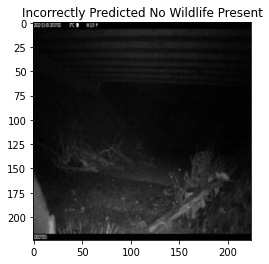

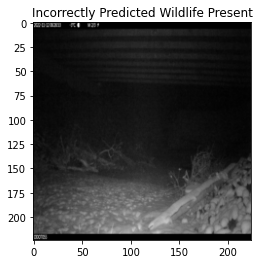

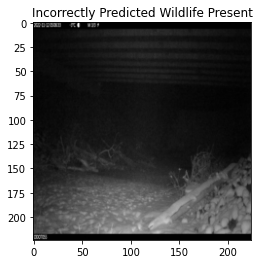

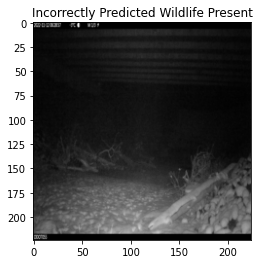

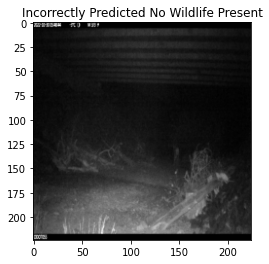

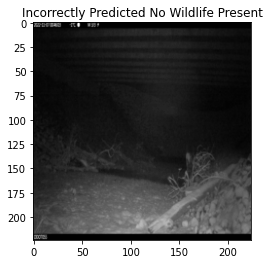

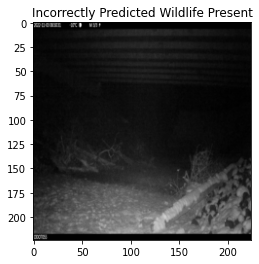

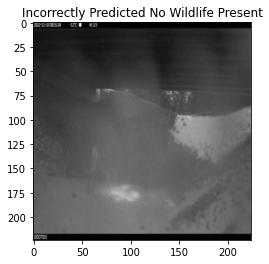

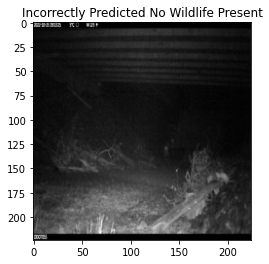

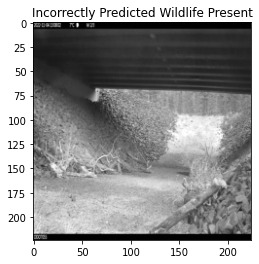

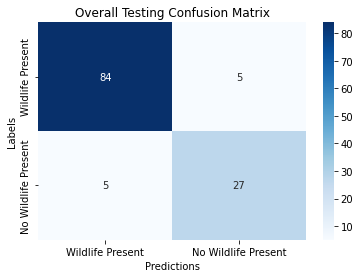

Overall Accuracy: 0.9173553719008265
Overall Precision: 0.9438202247191011
Overall Recall: 0.9438202247191011
Overall F-Score: 0.9438202247191011


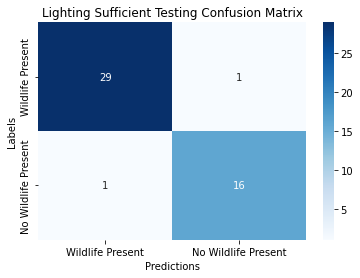

Lighting Sufficient Accuracy: 0.9574468085106383
Lighting Sufficient Precision: 0.9666666666666667
Lighting Sufficient Recall: 0.9666666666666667
Lighting Sufficient F-Score: 0.9666666666666667


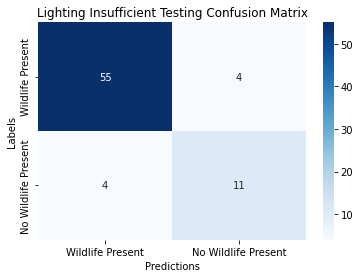

Lighting Insufficient Accuracy: 0.8918918918918919
Lighting Insufficient Precision: 0.9322033898305084
Lighting Insufficient Recall: 0.9322033898305084
Lighting Insufficient F-Score: 0.9322033898305084


In [13]:
train_and_test_ResNet152(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes)


Training and Testing Vision Transformer Large 16


Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth


  0%|          | 0.00/1.13G [00:00<?, ?B/s]

epoch: 0
training loss: 0.15949135220625213 and training accuracy: 0.6703910614525139
testing loss: 0.04329787787388672 and testing accuracy: 0.8016528925619835
epoch: 1
training loss: 0.0324295475954117 and training accuracy: 0.835195530726257
testing loss: 0.07030759850316796 and testing accuracy: 0.7851239669421488
epoch: 2
training loss: 0.0260827106231168 and training accuracy: 0.88268156424581
testing loss: 0.030358991208524744 and testing accuracy: 0.8925619834710744
epoch: 3
training loss: 0.013233742136872432 and training accuracy: 0.9497206703910615
testing loss: 0.027927492298801575 and testing accuracy: 0.859504132231405
epoch: 4
training loss: 0.010156966334172426 and training accuracy: 0.9581005586592178
testing loss: 0.020485722359793245 and testing accuracy: 0.9090909090909091


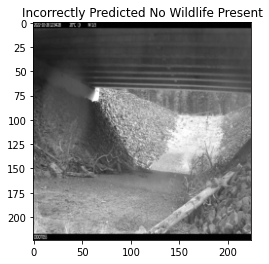

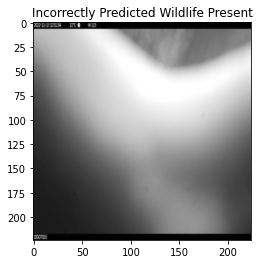

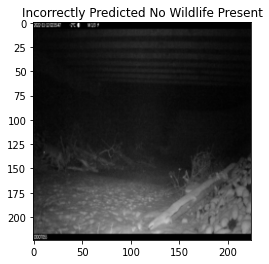

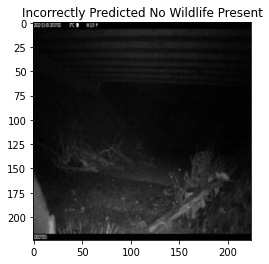

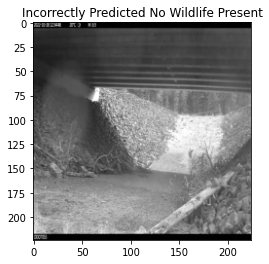

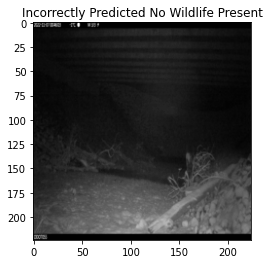

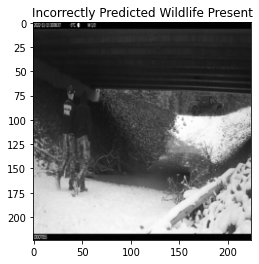

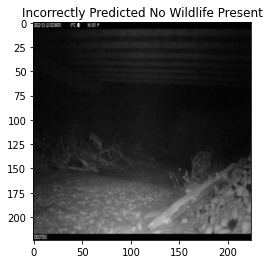

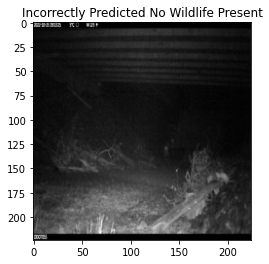

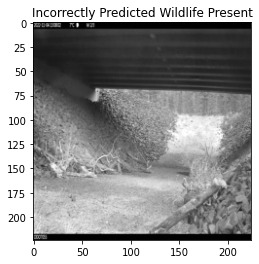

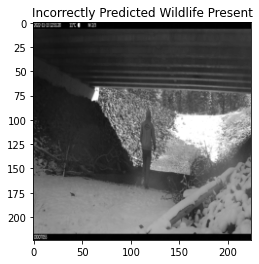

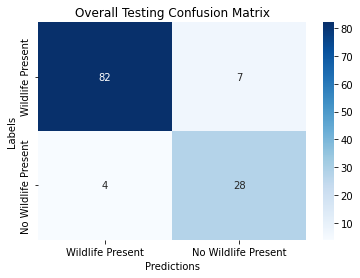

Overall Accuracy: 0.9090909090909091
Overall Precision: 0.9534883720930233
Overall Recall: 0.9213483146067416
Overall F-Score: 0.9371428571428573


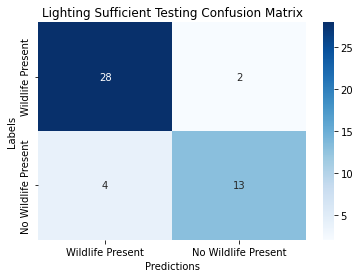

Lighting Sufficient Accuracy: 0.8723404255319149
Lighting Sufficient Precision: 0.875
Lighting Sufficient Recall: 0.9333333333333333
Lighting Sufficient F-Score: 0.9032258064516129


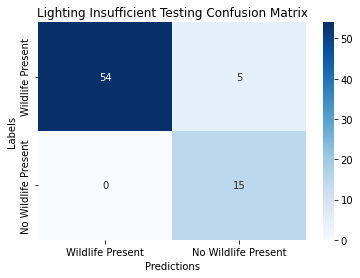

Lighting Insufficient Accuracy: 0.9324324324324325
Lighting Insufficient Precision: 1.0
Lighting Insufficient Recall: 0.9152542372881356
Lighting Insufficient F-Score: 0.9557522123893806


In [14]:
train_and_test_ViT_L_16(training_loader, testing_loader, ls_testing_loader, lis_testing_loader, device, num_classes)